# Mars Craters Detection

### Pre-processing steps
- Cover Mars map with quadrangles
- select a few relevant quadrangles, close to the equator, thus only a little distorted
- reprojection to correct the distortions
- craters: radius from 5 to 28 pixels

In [19]:
import numpy as np

import pandas as pd

from utils import *

from matplotlib.patches import Circle


In [13]:
# !pip install -r requirements.txt

Let's take a look at the data

In [50]:
X_train = np.load('data/data_train.npy', mmap_mode='r')
X_test = np.load('data/data_test.npy', mmap_mode='r')

y_train = pd.read_csv('data/labels_train.csv')
y_test = pd.read_csv('data/labels_test.csv')

print("The train data is made of {} images of {}x{} pixels".format(*X_train.shape))
print("The train data is made of {} images of {}x{} pixels".format(*X_test.shape))


n_img = len(X_train)

The train data is made of 7500 images of 224x224 pixels
The train data is made of 4000 images of 224x224 pixels


Let's see some images

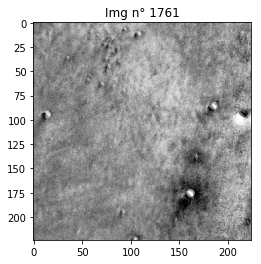

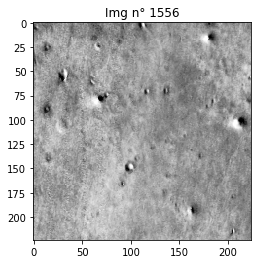

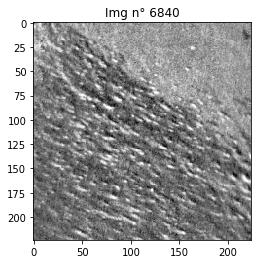

In [10]:
show_images(n_images=3, imgs=X_train, cmap='Greys_r')

In [15]:
y_train.head()

,i,row_p,col_p,radius_p
0,0,57.0,175.0,6.70
1,1,57.0,7.0,6.70
2,4,37.0,70.0,5.25
3,4,121.0,66.0,8.35
4,7,145.0,71.0,6.70


In [17]:
idx_list = [30, 3470, 7030]

Let's plot images + labels

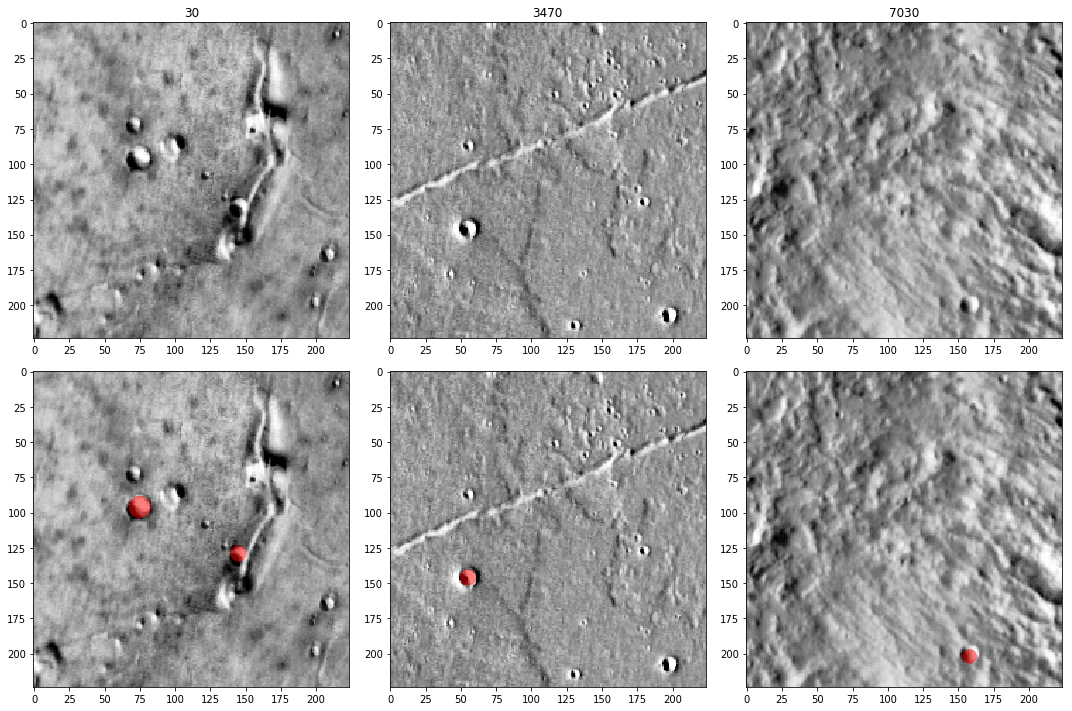

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, idx in enumerate(idx_list):
    img = X_train[idx]
    lab = y_train[y_train['i'] == idx][['row_p', 'col_p', 'radius_p']].values
    # First row images only
    axes[0, i].imshow(img, cmap='Greys_r')
    axes[0, i].set_title('%d' % idx)
    # Second row, labels overlaid on the image
    axes[1, i].imshow(img, cmap='Greys_r')
    if lab.size != 0:
        for y, x, radius in lab:
            crater = Circle((x, y), radius, color='r', ec=None, alpha=0.5)
            axes[1, i].add_patch(crater)
fig.tight_layout()

In [40]:
print("There are {} labeled craters in the training set".format(y_train.shape[0]))

There are 7541 labeled craters in the training set


In [42]:
n_img_withcraters = y_train['i'].unique().size

print("There are labeled craters for only {:.1%} of the images".format(n_img_withcraters / n_img))

There are labeled craters for only 57.0% of the images


Text(0.5, 1.0, 'Crater radius frequency for the training data')

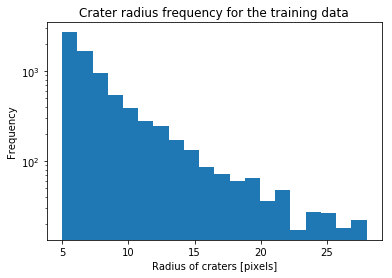

In [43]:
y_train.radius_p.plot(kind='hist', bins=20, log=True)
plt.xlabel('Radius of craters [pixels]')
plt.title('Crater radius frequency for the training data')

### To-do
- Convert round circles to bounding boxes
- Get train, valid and test data

### Qs
- 

### SSD steps
- Generate multiple boxes?
- keep only boxes that overlap with GT > 0.5
- Define loss function ... 
- To handle different ratios: use the output feature maps of different layers. Previous work: using feature maps for previous layes improves semantic seg
- 

### Extra step: build classification model

- Build classif label

In [ ]:
y_train_classification = y_train.copy()
y_train_classification["has_crater"] = 1
y_train_classification = y_train_classification.drop_duplicates(subset="i")
y_train_classification = y_train_classification[["i", "has_crater"]]
y_train_classification = y_train_classification.set_index("i")
new_index = list(range(7500))
y_train_classification = y_train_classification.reindex(new_index, fill_value=0)

In [54]:
X_train[0].shape

(224, 224)

In [63]:
config = {
    "n_classes" : 1,
    "mode" : 'train',
    "img_width" : 224,
    "img_height" : 224,
    "base_filter_nums" : [34, 48, 64, 64, 48, 48, 32],
    "base_filter_sizes" : [5, 3, 3, 3, 3, 3, 3],
    "pool_sizes" : [2, 2, 2, 2, 2, 2, None]
}

In [56]:
import tensorflow as tf

In [110]:
class CraterClassifier:

    def __init__(self, config):
        self.config = config
        self.n_classes = config["n_classes"]
        self.img_width = config["img_width"]
        self.img_height = config["img_height"]
        self.base_filter_nums = config["base_filter_nums"]
        self.base_filter_sizes = config["base_filter_sizes"]
        self.pool_sizes = config["pool_sizes"]
        

    def build_graph(self):
        
        tf.reset_default_graph()
        
        self.X_placeholder = tf.placeholder(tf.float32, shape=(None, self.img_width, self.img_height), name='input')
        self.y_placeholder = tf.placeholder(tf.float32, shape=(None, 1), name='label')
        
        n_convs = len(self.base_filter_nums)
            
        # Conv block 1
        i = 0    
        filters_num = self.base_filter_nums[i]
        filter_size = self.base_filter_sizes[i]
        pool_size = self.pool_sizes[i]
        # Conv2D
        net = tf.layers.conv2d(inputs=self.X_placeholder, filters=filters_num, 
                               kernel_size=(filter_size, filter_size), name='conv_'+str(i))
        # Batch Norm
        net = tf.layers.batch_normalization(inputs=net, name='bn_'+str(i))
        # Max Pooling
        net = tf.layers.max_pooling2d(inputs=net, pool_size=(pool_size, pool_size), name="pool_"+str(i))
        
        # Conv blocks 2, 3, 4, 5, 6
        for i in range(1, n_convs - 1):
            filters_num = self.base_filter_nums[i]
            filter_size = self.base_filter_sizes[i]
            pool_size = self.pool_sizes[i]
            # Conv2D
            net = tf.layers.conv2d(inputs=net, filters=filters_num, 
                                   kernel_size=(filter_size, filter_size), name='conv_'+str(i))
            # Batch Norm
            net = tf.layers.batch_normalization(inputs=net, name='bn_'+str(i))
            # Max Pooling
            net = tf.layers.max_pooling2d(inputs=net, pool_size=(pool_size, pool_size), name="pool_"+str(i))
            
        # Conv block 7    
        i = n_convs - 1
        filters_num = self.base_filter_nums[i]
        filter_size = self.base_filter_sizes[i]
        pool_size = self.pool_sizes[i]
        # Conv2D
        net = tf.layers.conv2d(inputs=self.X_placeholder, filters=filters_num, 
                               kernel_size=(filter_size, filter_size), name='conv_'+str(i))
        # Batch Norm
        net = tf.layers.batch_normalization(inputs=net, name='bn_'+str(i))
        
        logit = tf.contrib.layers.fully_connected(net, 1, activation_fn=None)
        self.prediction = tf.nn.sigmoid(logit)
        flat_target = tf.reshape(self.y_placeholder, [-1] + self.y_placeholder.shape.as_list()[2:])
        flat_logit = tf.reshape(logit, [-1] + logit.shape.as_list()[2:])
        
        # Cross-entropy loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=flat_target, logits=flat_logit)
        self.loss = tf.reduce_mean(loss)
        
        # Adam optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.initial_lr).minimize(self.loss)
        
        
        correct_pred = tf.equal(tf.cast(tf.round(self.prediction), tf.float32), self.y_placeholder)
        self.acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        
        tf.summary.scalar("loss", self.loss)
        tf.summary.scalar("accuracy", self.acc)
        
        self.merged_summary_op = tf.summary.merge_all()

        self.init_global = tf.global_variables_initializer()
        self.init_local = tf.local_variables_initializer()
        
        
    def fit(self, X, y, session):
        pass

    def predict(self, X, session):
        y_pred = 0

        return y_pred

In [65]:
class ObjectDetector:

    def __init__(self, config):
        self.config = config
        self.n_classes = config["n_classes"]
        self.img_width = config["img_width"]
        self.img_height = config["img_height"]
        self.base_filter_nums = config["base_filter_nums"]
        self.base_filter_sizes = config["base_filter_sizes"]
        self.pool_sizes = config["pool_sizes"]
        

    def build_graph(self):
        self.X_placeholder = tf.placeholder(tf.float32, shape=(None, self.img_width, self.img_height), name='input')
        
        n_convs = len(self.base_filter_nums)
            
        # Conv block 1
        i = 0    
        filters_num = self.base_filter_nums[i]
        filter_size = self.base_filter_sizes[i]
        pool_size = self.pool_sizes[i]
        # Conv2D
        net = tf.layers.conv2d(inputs=self.X_placeholder, filters=filters_num, 
                               kernel_size=(filter_size, filter_size), name='conv_'+str(i))
        # Batch Norm
        net = tf.layers.batch_normalization(inputs=net, name='bn_'+str(i))
        # Max Pooling
        net = tf.layers.max_pooling2d(inputs=net, pool_size=(pool_size, pool_size), name="pool_"+str(i))
        
        # Conv blocks 2, 3, 4, 5, 6
        for i in range(1, n_convs - 1):
            filters_num = self.base_filter_nums[i]
            filter_size = self.base_filter_sizes[i]
            pool_size = self.pool_sizes[i]
            # Conv2D
            net = tf.layers.conv2d(inputs=net, filters=filters_num, 
                                   kernel_size=(filter_size, filter_size), name='conv_'+str(i))
            # Batch Norm
            net = tf.layers.batch_normalization(inputs=net, name='bn_'+str(i))
            # Max Pooling
            net = tf.layers.max_pooling2d(inputs=net, pool_size=(pool_size, pool_size), name="pool_"+str(i))
            
        # Conv block 7    
        i = n_convs - 1
        filters_num = self.base_filter_nums[i]
        filter_size = self.base_filter_sizes[i]
        pool_size = self.pool_sizes[i]
        # Conv2D
        net = tf.layers.conv2d(inputs=self.X_placeholder, filters=filters_num, 
                               kernel_size=(filter_size, filter_size), name='conv_'+str(i))
        # Batch Norm
        net = tf.layers.batch_normalization(inputs=net, name='bn_'+str(i))
        
        
        
        

    def fit(self, X, y, session):
        pass

    def predict(self, X, session):
        y_pred = 0

        return y_pred

In [66]:
def build_conv2d():
    pass

In [67]:
model = ObjectDetector(config=config)

In [71]:
tf.GraphKeys()

In [68]:
!tensorboard --logdir=/Users/Oumayma/Py